In [0]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import numpy as np
import cv2
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import os, sys
import random
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def calculate_per_pixel_change(img1, img2):
    #epsilon = 1e-5
    #img1_normalized = (img1 - img1.mean(axis=0)) / (img1.std(axis=0) + epsilon)
    #img2_normalized = (img2 - img2.mean(axis=0)) / (img2.std(axis=0) + epsilon)
    #img_diff = img1_normalized - img2_normalized
    img_diff = img1 - img2
    img_diff[img_diff<0] = 0
    manhattan_norm = np.sum(abs(img_diff))
    zero_norm = np.linalg.norm(img_diff.ravel(), 0)
    return manhattan_norm, zero_norm


In [0]:
def run_sift(color1,color2,dir1=None,dir=None,fname1=None,fname2=None):
    img1 = cv2.cvtColor(color1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(color2, cv2.COLOR_BGR2GRAY)

    sift = cv2.xfeatures2d.SURF_create()
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    output1 = cv2.drawKeypoints(color1,kp1,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    output2 = cv2.drawKeypoints(color2,kp2,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    bf = cv2.BFMatcher(normType=cv2.NORM_L2)
    matches = bf.knnMatch(des1, des2, k=2)
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    sortedgood = sorted(good, key = lambda x:x.distance)
    draw = sortedgood[:20]
    output3 = cv2.drawMatches(color1,kp1,color2,kp2,draw,None,flags=2)
    #cv2.imwrite(os.path.join(dir2, fname2) + '_matches.tif', output3)

    if len(good) >= 4:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    else:
        print('NOT ENOUGH MATCHES FOR HOMOGRAPHY')
        return

    H = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)[0]
    # dst = cv2.warpPerspective(color2, H, (img1.shape[1] + img2.shape[1], img1.shape[0]))
    # dst[0:img1.shape[0], 0:img1.shape[1]] = color1
    # cv2.imwrite(os.path.join(dir2, fname2) + '_stitched.tif', dst)
    #dst = cv2.warpPerspective(color2, H, img2.shape)
    #cv2.imwrite(os.path.join(dir2, fname2) + '_homography.tif', dst)
    return H 



In [0]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

2031101_5658.tif 0.13849323658514734 0.1375078383946967


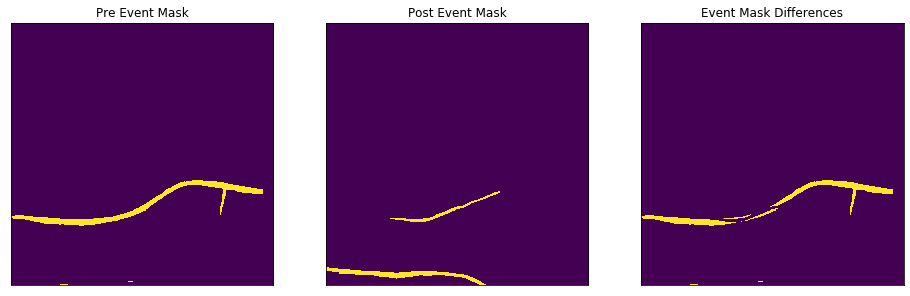

2031101_11291.tif 0.10177514792899411 0.1010650887573965


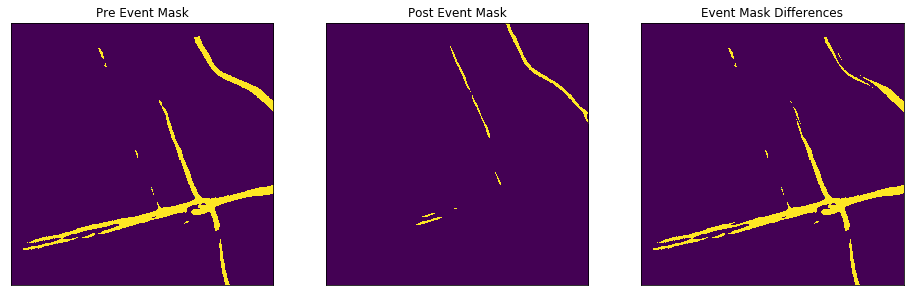

2031101_7700.tif 0.18262313226342008 0.18262313226342008


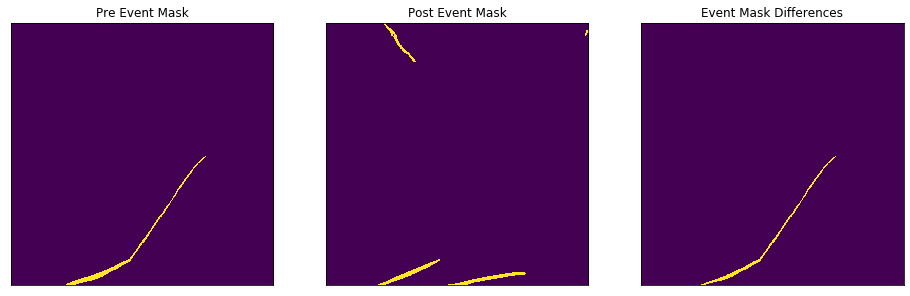

2031101_14.tif 0.14237288135593218 0.14083204930662563


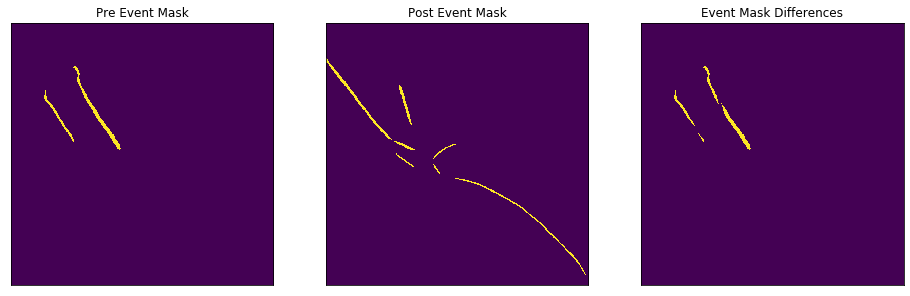

2031101_10780.tif 0.13724137931034486 0.13724137931034486


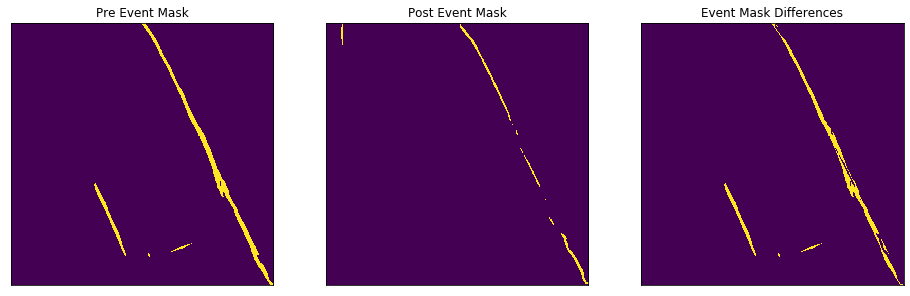

2031101_3087.tif 0.3354838709677419 0.3354838709677419


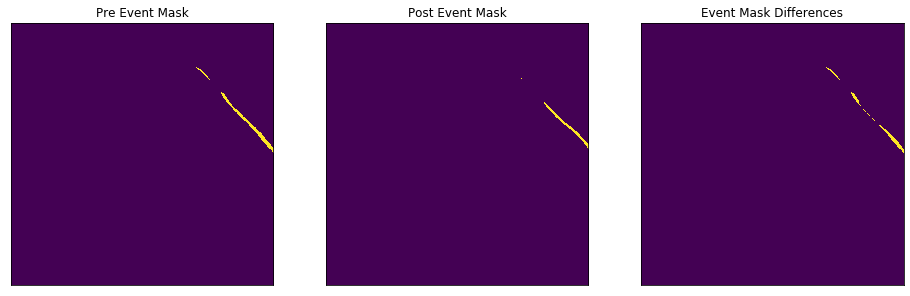

2031101_6175.tif 0.17091260883585935 0.17091260883585935


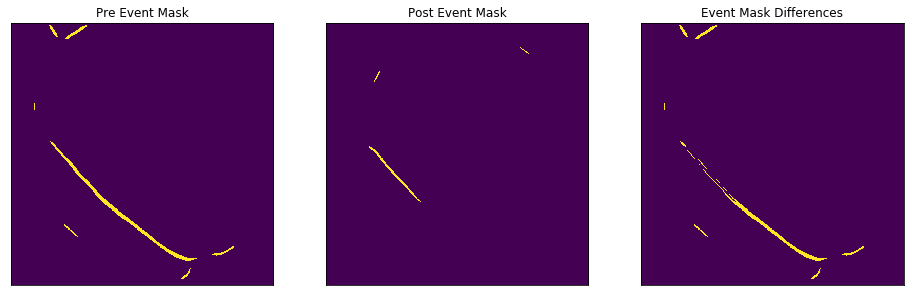

2031101_10778.tif 0.11422845691382766 0.11422845691382766


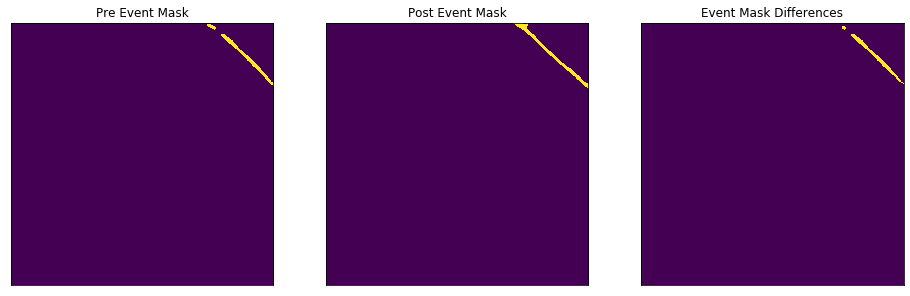

2031101_5661.tif 0.16782029515476038 0.16677549954290194


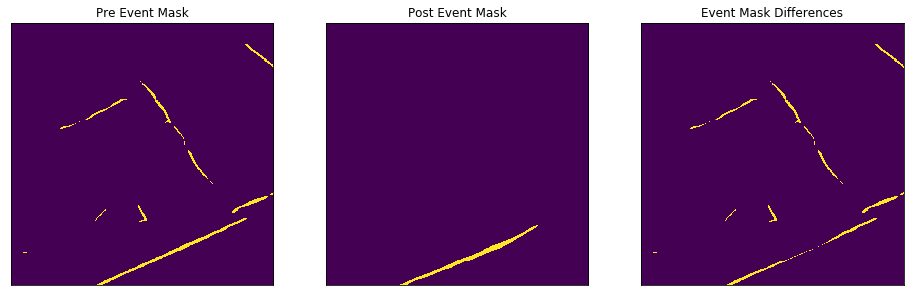

2031101_10775.tif 0.18856447688564482 0.18856447688564482


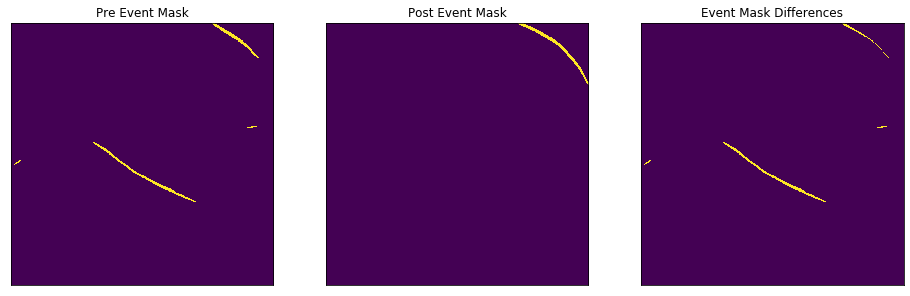

2031101_3088.tif 0.5420792079207921 0.5420792079207921


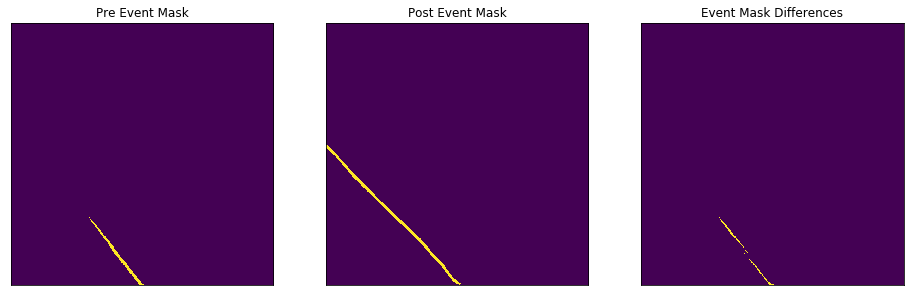

In [139]:
#mask_dir = '/content/drive/My Drive/cs461-final-project/predictions/'
mask_dir = '/content/drive/My Drive/cs461-final-project/predictions_unet/'
pre_dir = '/content/drive/My Drive/cs461-final-project/data/disaster_images/pre_event'
post_dir = '/content/drive/My Drive/cs461-final-project/data/disaster_images/post_event'
homographies = '/content/drive/My Drive/homographies.txt'
homo = {}
import re

with open(homographies) as fin:
  fname = None
  row = 0 
  mat =  np.zeros((3, 3))
  for line in fin:
    if line != '\n':
      if 'tif' in line: 
        fname = line.replace('\n', '')
        row = 0
      else: 
        #print("line: ", line)
        line = line.replace('[','')
        line = line.replace(']', '')
        line = line.replace(', ', '')
        #print("post stripping line: ", line)
        #print([float(num) for num in line.split(' ') if num!=''])
        mat[row] = np.asarray([float(num) for num in line.split(' ') if num!=''])
        row = row + 1
        if row == 3: 
          homo[fname] = mat
          mat =  np.zeros((3, 3))  
          row = 0
          fname = None
#print(homo)
files = os.listdir(mask_dir)
for f in files: 
  if 'pre' in f:
    pre = f
    post = pre.replace('pre', 'post')

    source = pre.replace('jpg', 'tif')
    source = source.replace('_pre', '')
    #print(source)

    pre_source = cv2.imread(os.path.join(pre_dir, source), cv2.IMREAD_COLOR)
    post_source = cv2.imread(os.path.join(post_dir, source), cv2.IMREAD_COLOR)

    #homo = run_sift(pre_source, post_source)
    h = np.array([])
    #print(h.size)
    if source in homo:
      h = homo[source]
      #print(h)
    pre_mask = cv2.imread(os.path.join(mask_dir, pre), cv2.IMREAD_GRAYSCALE) / 255.0
    if h.size != 0: 
      pre_mask = cv2.warpPerspective(pre_mask, h, pre_mask.shape)

    post_mask = cv2.imread(os.path.join(mask_dir, post), cv2.IMREAD_GRAYSCALE) / 255.0
    pre_mask[pre_mask>0.5] = 1
    pre_mask[pre_mask<0.5] = 0

    post_mask[post_mask>0.5] = 1
    post_mask[post_mask<0.5] = 0
    manhattan_norm, zero_norm = calculate_per_pixel_change(pre_mask, post_mask)
    #print(pre, source, 1-manhattan_norm/np.sum(pre_mask), 1-zero_norm/np.sum(pre_mask))
    access_index1 = 1-manhattan_norm/np.sum(pre_mask)
    access_index2 = 1-zero_norm/np.sum(pre_mask)
    img_diff = pre_mask - post_mask
    img_diff[img_diff<0] = 0
    if(access_index1 > 0.1 or access_index2 > 0.1):
      print(source, access_index1, access_index2)
      visualize(
          pre_event_mask = pre_mask, 
          post_event_mask = post_mask, 
          event_mask_differences=img_diff
      )
    #print("Manhattan norm: {} per pizel: {}".format(manhattan_norm, manhattan_norm / cv2.GetSize(gray1)))
    #print("Zero norm: {} per pizel: {}".format(zero_norm, zero_norm / cv2.GetSize(gray1)))

#img1 = cv2.imread(os.path.join(args.directory, args.img1), cv2.IMREAD_COLOR)
#img2 = cv2.imread(os.path.join(args.directory, args.img2), cv2.IMREAD_COLOR)
#gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) / 255.0
#gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY) / 255.0
#manhattan_norm, zero_norm = calculate_per_pixel_change(gray1, gray2)
#print("Manhattan norm: {} per pizel: {}".format(manhattan_norm, manhattan_norm / cv.GetSize(gray1)))
#print("Zero norm: {} per pizel: {}".format(zero_norm, zero_norm / cv.GetSize(gray1)))
